In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
plt.style.use("dark_background")

df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['age', 'fare']],
    df['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [3]:
ort = X_train.mean().to_dict()
X_train.fillna(ort,inplace=True)
X_test.fillna(ort,inplace=True)

In [4]:
tree_model = DecisionTreeClassifier(max_depth =3)

tree_model.fit(X_train[["age"]],y_train)

X_train["age_tree"] = tree_model.predict_proba(X_train[["age"]])[:,1]
X_train.head(10)

,age,fare,age_tree
857,51.000000,26.5500,0.357143
52,49.000000,76.7292,0.357143
386,1.000000,46.9000,0.500000
124,54.000000,77.2875,0.357143
578,29.915339,14.4583,0.342029
549,8.000000,36.7500,0.500000
118,24.000000,247.5208,0.342029
12,20.000000,8.0500,0.342029
157,30.000000,8.0500,0.342029
127,24.000000,7.1417,0.342029


In [5]:
X_train.age_tree.unique()

array([0.35714286, 0.5       , 0.34202899, 0.50632911, 1.        ,
       0.875     , 0.        ])

In [6]:
pd.concat([X_train,y_train],axis=1).groupby(["age_tree"]).mean()

,age,fare,survived
age_tree,,,
0.000000,30.500000,7.900000,0.000000
0.342029,25.709438,25.910687,0.342029
0.357143,47.853571,42.563036,0.357143
0.500000,4.931818,33.521686,0.500000
0.506329,33.841772,40.134070,0.506329
0.875000,14.062500,53.635950,0.875000
1.000000,0.800000,46.611660,1.000000


In [7]:
pd.concat([X_train,y_train],axis=1).groupby(["age_tree"])["survived"].mean()

age_tree
0.000000    0.000000
0.342029    0.342029
0.357143    0.357143
0.500000    0.500000
0.506329    0.506329
0.875000    0.875000
1.000000    1.000000
Name: survived, dtype: float64

In [8]:
y_train.groupby(X_train["age_tree"]).mean()

age_tree
0.000000    0.000000
0.342029    0.342029
0.357143    0.357143
0.500000    0.500000
0.506329    0.506329
0.875000    0.875000
1.000000    1.000000
Name: survived, dtype: float64

<Axes: xlabel='age_tree'>

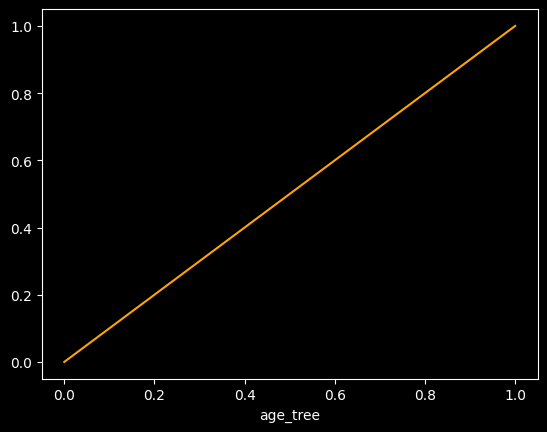

In [10]:
pd.concat([X_train,y_train],axis=1).groupby(["age_tree"])["survived"].mean().plot(color="orange")

<Axes: xlabel='age_tree'>

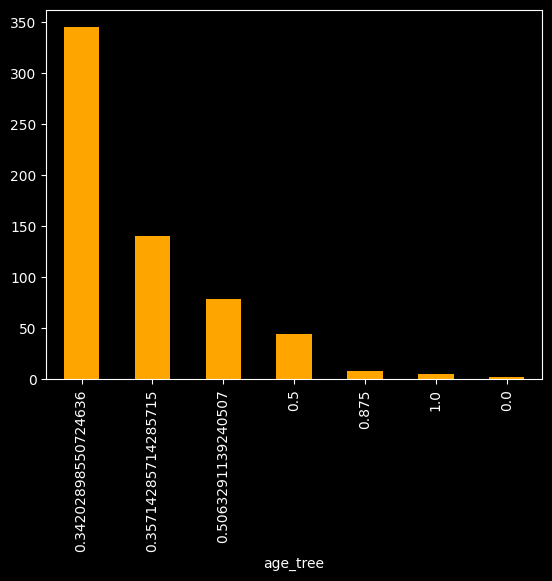

In [11]:
X_train["age_tree"].value_counts().plot.bar(color = "orange")

<Axes: xlabel='age_tree'>

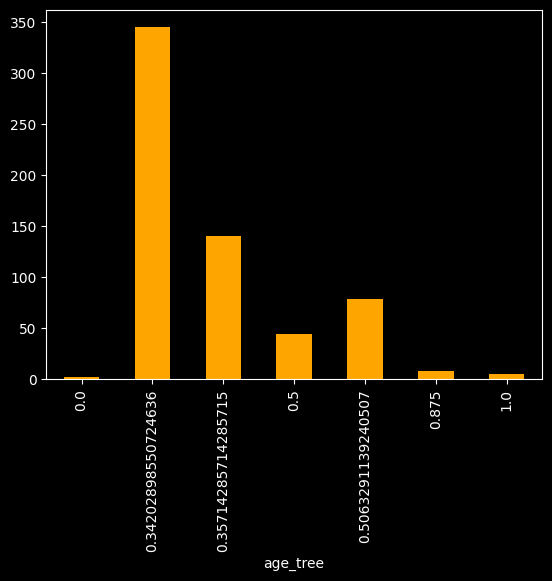

In [12]:
X_train.groupby("age_tree")["age"].count().plot.bar(color = "orange")

<Axes: xlabel='age_tree'>

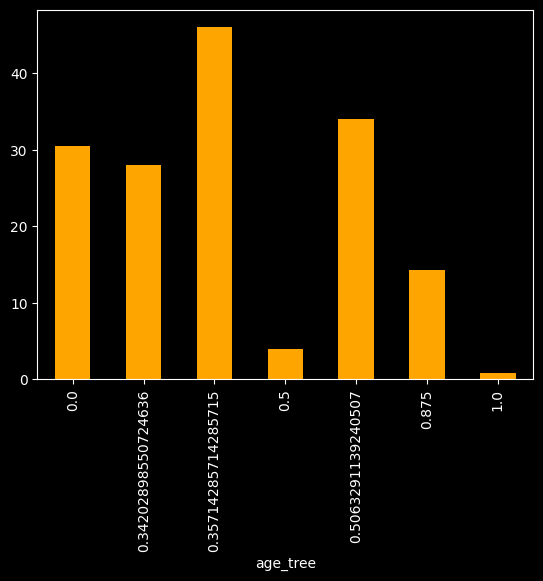

In [13]:
X_train.groupby("age_tree")["age"].median().plot.bar(color = "orange")

In [15]:
X_train.groupby("age_tree")["age"].mean()

age_tree
0.000000    30.500000
0.342029    25.709438
0.357143    47.853571
0.500000     4.931818
0.506329    33.841772
0.875000    14.062500
1.000000     0.800000
Name: age, dtype: float64

<Axes: xlabel='age_tree'>

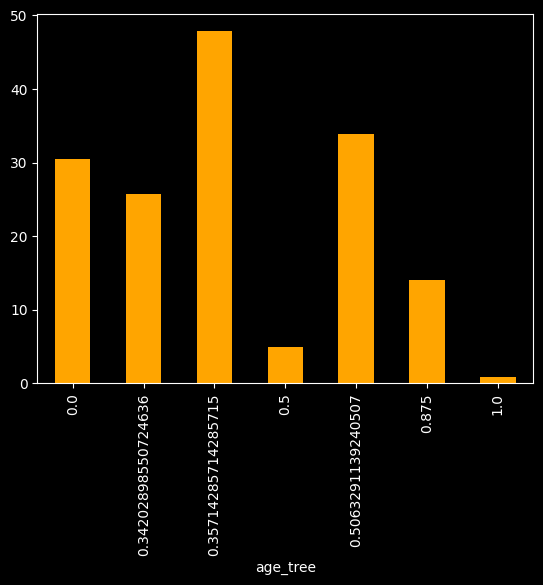

In [14]:
X_train.groupby("age_tree")["age"].mean().plot.bar(color = "orange")

In [13]:
X_train.pivot_table(index="age_tree",values="age",aggfunc=["min","max"])

,min,max
,age,age
age_tree,,
0.000000,30.50,30.50
0.342029,16.00,30.00
0.357143,36.50,80.00
0.500000,1.00,11.00
0.506329,31.00,36.00
0.875000,12.00,15.00
1.000000,0.67,0.92


<Axes: xlabel='age_tree'>

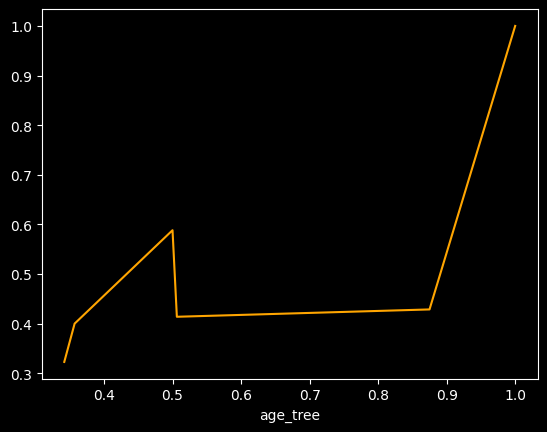

In [16]:
X_test["age_tree"] = tree_model.predict_proba(X_test[["age"]])[:,1]
y_test.groupby(X_test["age_tree"]).mean().plot(color="orange")

In [18]:
from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier()
param_grid = {
    'max_depth': range(1, 5),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10),
}

grid_search = GridSearchCV(dtc, param_grid, cv=10, scoring="roc_auc")

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

results = results[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score']]

In [19]:
results.sort_values(by="mean_test_score",ascending=False)

,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,std_test_score
281,4,3,9,0.679078,0.067337
283,4,5,9,0.678672,0.067036
286,4,8,9,0.678256,0.067072
284,4,6,9,0.678256,0.067072
285,4,7,9,0.678146,0.066921
...,...,...,...,...,...
49,1,3,7,0.612998,0.062309
50,1,4,7,0.612998,0.062309
51,1,5,7,0.612998,0.062309
52,1,6,7,0.612998,0.062309


In [70]:
from feature_engine.discretisation import DecisionTreeDiscretiser

disc = DecisionTreeDiscretiser(cv=10,scoring="roc_auc",
                               variables=["age","fare"],
                               regression=False,
                               param_grid={'max_depth': range(2,5),
                                           'min_samples_split': range(2, 10),
                                           'min_samples_leaf': [2,4,5]})
disc.fit(X_train[["age","fare"]],y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': range(2, 5),
                                    'min_samples_leaf': [2, 4, 5],
                                    'min_samples_split': range(2, 10)},
                        regression=False, scoring='roc_auc',
                        variables=['age', 'fare'])

In [71]:
disc.binner_dict_["age"].best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [72]:
disc.binner_dict_["fare"].best_params_

{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 9}

In [73]:
disc.scores_dict_["age"]

0.6125246740851608

In [74]:
model = DecisionTreeClassifier(**disc.binner_dict_["age"].best_params_)
model.fit(X_train[["age"]],y_train)
X_train["age_grid_disc"] = model.predict_proba(X_train[["age"]])[:,1]

<Axes: xlabel='age_grid_disc'>

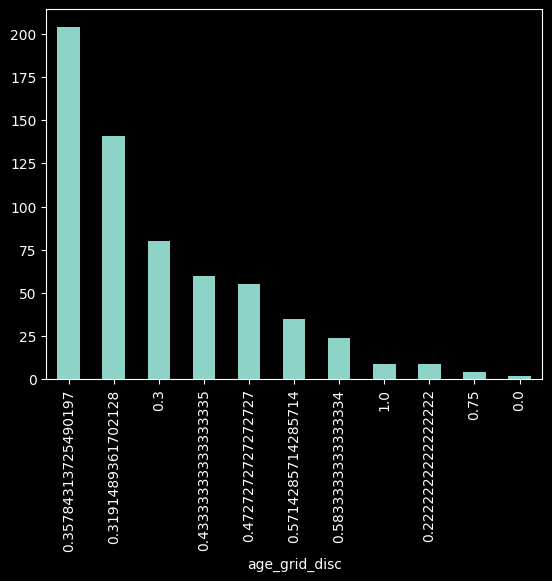

In [75]:
X_train.age_grid_disc.value_counts().plot.bar()

In [76]:
disc.transform(X_train[["age","fare"]])["age"].unique()

array([0.43333333, 0.57142857, 0.31914894, 0.35784314, 0.47272727,
       0.3       , 1.        , 0.58333333, 0.22222222, 0.75      ,
       0.        ])

In [77]:
test_t = disc.transform(X_test[["age","fare"]])
test_t

,age,fare
495,0.319149,0.429630
648,0.319149,0.338462
278,0.571429,0.429630
31,0.319149,0.882353
255,0.357843,0.429630
...,...,...
263,0.300000,0.000000
718,0.319149,0.429630
620,0.357843,0.429630
786,0.357843,0.095238


<Axes: xlabel='age'>

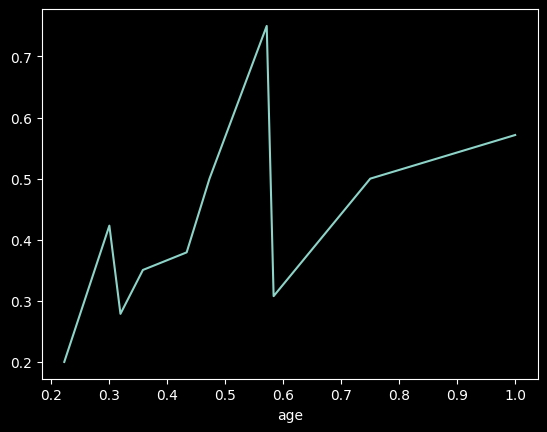

In [78]:
y_test.groupby(test_t["age"]).mean().plot()